In [37]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [38]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [39]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [40]:
A,D = 1.0,10.0
tau_real = A/D
delta_t_list=np.linspace(0.001,1,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [41]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

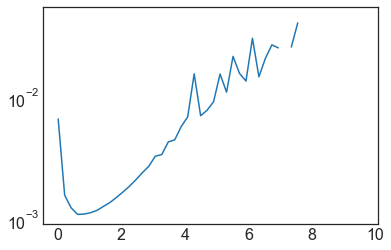

In [42]:
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3])

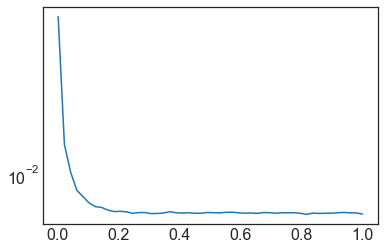

In [43]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [44]:
A,D = 1.0,10.0
tau_real = A/D
delta_t_list=np.linspace(0.001,1,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

0.1437142857142857


In [45]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=20000

In [46]:
trace = sm.run(x=data,
                d_bound=50,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1669.93draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
The acceptance probability does not match the target. It is 0.8838911579666279, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809010873389723, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c1d25d5c0>,
      dtype=object)

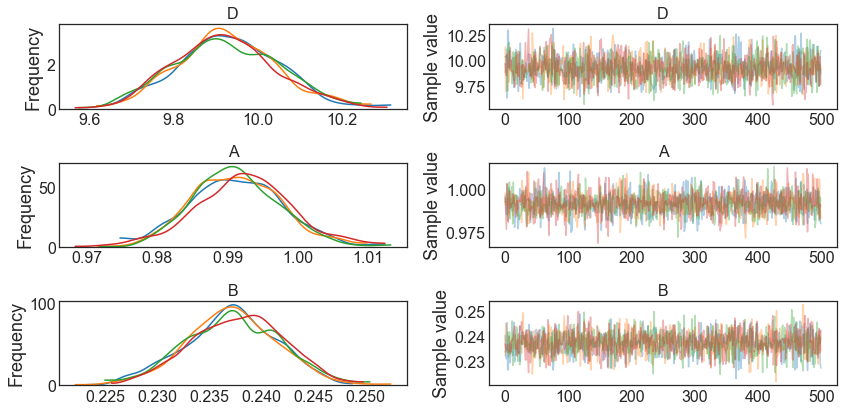

In [47]:
pm.traceplot(trace)

In [48]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.001


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:02<00:00, 1588.15draws/s]
/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.021387755102040818


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1195.58draws/s]
The acceptance probability does not match the target. It is 0.88328698855059, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.041775510204081635


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1054.34draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8871158218800289, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.062163265306122456


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1121.88draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.08255102040816327


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1051.09draws/s]
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6541828002513009, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.10293877551020408


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 930.24draws/s] 
The acceptance probability does not match the target. It is 0.8918065148140373, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.12332653061224491


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1155.19draws/s]
The acceptance probability does not match the target. It is 0.9059788139470302, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.1437142857142857


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 990.84draws/s] 
The acceptance probability does not match the target. It is 0.8883640508434938, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.88862872348371, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8897976038936424, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.16410204081632654


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 999.20draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8927945973704341, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.18448979591836737


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 903.77draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.20487755102040817


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 861.65draws/s] 
The acceptance probability does not match the target. It is 0.898551429811791, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.225265306122449


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 858.34draws/s] 
The acceptance probability does not match the target. It is 0.8934842676660767, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.24565306122448982


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 922.77draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.26604081632653065


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 930.96draws/s] 
The acceptance probability does not match the target. It is 0.8871055827579567, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.2864285714285714


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 991.52draws/s] 
The acceptance probability does not match the target. It is 0.9031099836253647, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.30681632653061225


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 920.33draws/s] 
The acceptance probability does not match the target. It is 0.9002663693584281, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.3272040816326531


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 833.47draws/s] 
The acceptance probability does not match the target. It is 0.8821717112509012, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8933313037306193, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.3475918367346939


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 724.03draws/s] 
The acceptance probability does not match the target. It is 0.8799088036685495, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.36797959183673473


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 795.49draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.3883673469387755


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1033.87draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.40875510204081633


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1038.83draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8934173019221247, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.42914285714285716


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 758.26draws/s] 
The acceptance probability does not match the target. It is 0.8786925391964201, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8826662185624291, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8800280996829348, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.449530612244898


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1062.70draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.4699183673469388


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1043.66draws/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.49030612244897964


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 896.83draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5106938775510205


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 947.46draws/s] 
The acceptance probability does not match the target. It is 0.9005765673845172, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5310816326530613


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 778.42draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.551469387755102


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 899.69draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5718571428571428


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 921.12draws/s] 
The acceptance probability does not match the target. It is 0.9036037006198099, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.5922448979591837


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 722.15draws/s] 
The acceptance probability does not match the target. It is 0.896955526817236, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.9118312620718845, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6126326530612245


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:03<00:00, 1126.99draws/s]
The acceptance probability does not match the target. It is 0.8878396587308791, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6330204081632653


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 772.26draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6534081632653062


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 832.75draws/s] 
The acceptance probability does not match the target. It is 0.8980896578406082, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.673795918367347


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 901.09draws/s] 
The acceptance probability does not match the target. It is 0.9014855913540984, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.6941836734693878


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 886.54draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7145714285714286


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 949.98draws/s] 
The acceptance probability does not match the target. It is 0.9126227583441358, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7349591836734695


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:06<00:00, 640.64draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7553469387755103


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 701.04draws/s] 
The acceptance probability does not match the target. It is 0.8825402703162625, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8993558394761181, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.775734693877551


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 745.52draws/s] 
The acceptance probability does not match the target. It is 0.8921872100004132, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.7961224489795918


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 704.64draws/s] 
The acceptance probability does not match the target. It is 0.8896120056849606, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8165102040816327


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 871.69draws/s] 
The acceptance probability does not match the target. It is 0.8853209929608957, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8368979591836735


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 719.85draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8960231500048595, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8572857142857143


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 898.03draws/s] 
The acceptance probability does not match the target. It is 0.8920693816250033, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.882159962829687, but should be close to 0.8. Try to increase the number of tuning steps.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.8776734693877551


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:06<00:00, 574.84draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.898061224489796


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 852.47draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9184489795918368


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 690.00draws/s] 
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9388367346938776


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 729.23draws/s] 
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8831141496552077, but should be close to 0.8. Try to increase the number of tuning steps.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9592244897959185


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:06<00:00, 629.12draws/s] 
The acceptance probability does not match the target. It is 0.9052980543622293, but should be close to 0.8. Try to increase the number of tuning steps.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


0.9796122448979593


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 749.77draws/s] 
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8834177404727789, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...


1.0


Multiprocess sampling (4 chains in 4 jobs)
NUTS: [A, D]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 748.73draws/s] 
The acceptance probability does not match the target. It is 0.8899365072427635, but should be close to 0.8. Try to increase the number of tuning steps.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


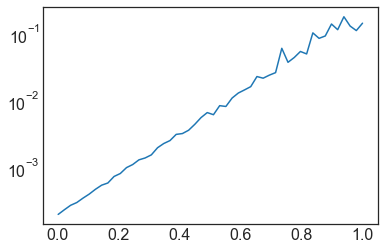

In [49]:
plt.semilogy(delta_t_list,result_array.T[3])

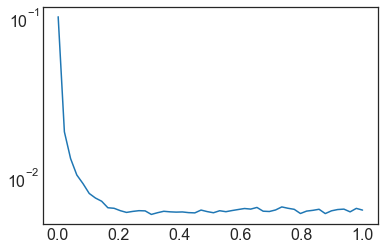

In [50]:
plt.semilogy(delta_t_list,result_array.T[1])

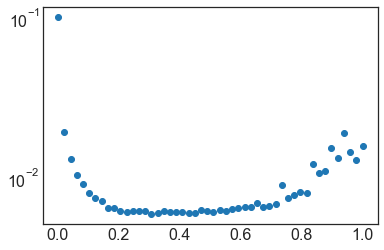

In [51]:
dtau = np.sqrt(result_array.T[1]**2/D**2+A**2/D**4*result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau/tau_real,"o")

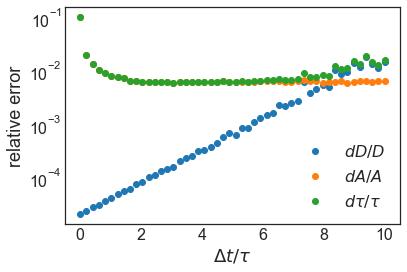

In [52]:
plt.semilogy(delta_t_list/tau_real,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list/tau_real,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list/tau_real,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

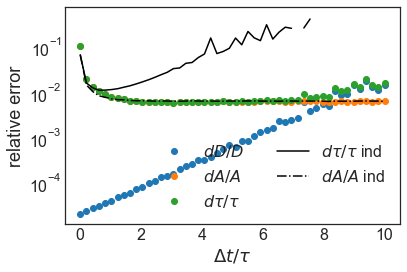

In [53]:
plt.semilogy(delta_t_list/tau_real,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list/tau_real,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list/tau_real,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list/tau_real,result_Bayes_array.T[1]/A,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_2.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")

In [54]:
result_array.T[3]

array([0.00020095, 0.00023599, 0.0002749 , 0.00030242, 0.00035193,
       0.00040425, 0.00047669, 0.00054918, 0.00059203, 0.00074098,
       0.00081988, 0.00100432, 0.00111611, 0.00131117, 0.00139952,
       0.00155691, 0.00199006, 0.00230005, 0.00254345, 0.00314832,
       0.00323795, 0.0036294 , 0.00445326, 0.00560606, 0.0066619 ,
       0.00619222, 0.00844737, 0.00822046, 0.0109755 , 0.01304288,
       0.01452502, 0.01624564, 0.02299014, 0.02173251, 0.02413255,
       0.02630353, 0.06069068, 0.03752206, 0.04420399, 0.05442998,
       0.05002651, 0.10315742, 0.08551007, 0.09276667, 0.13989375,
       0.11510669, 0.17965674, 0.13045541, 0.11167035, 0.14396003])